### Import libraries and read in file

In [14]:
# import libs
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import TimeSeriesSplit

plt.style.use('fivethirtyeight')

In [15]:
# read in file and define some useful column groupings
elec_w_weather_path = '/users/ianmyjer/desktop/disagg/electric_data_with_weather.csv'
df = pd.read_csv(elec_w_weather_path,delimiter=',',header=0,index_col=0,parse_dates=True)

In [16]:
# define useful column groupings
power_cols = ['north_br','south_br','basement','dryer','washer',
'dining_room','dishwasher','workbench','security_system',
'refrigerator','furnace_fan','garage','heat_pump',
'dhw_heater','main_house_total','office','outside_plug',
'rental_suite','entertainment','utility_room','unmetered',
'whole_house_total','oven']
weather_cols = ['Temp (C)', 'Dew Point Temp (C)', 'Rel Hum (%)', 
'Wind Spd (km/h)','Stn Press (kPa)']

In [19]:
df.columns

Index(['north_br', 'south_br', 'basement', 'dryer', 'washer', 'dining_room',
       'dishwasher', 'workbench', 'security_system', 'refrigerator',
       'furnace_fan', 'garage', 'heat_pump', 'dhw_heater', 'office',
       'outside_plug', 'rental_suite', 'entertainment', 'utility_room',
       'whole_house_total', 'oven', 'main_house_total', 'unmetered',
       'Temp (C)', 'Dew Point Temp (C)', 'Rel Hum (%)', 'Wind Spd (km/h)',
       'Stn Press (kPa)', 'dow', 'weekday', 'business_hours', 'hour', 'winter',
       'spring', 'summer', 'fall'],
      dtype='object')

### X Vars

In [20]:
# time-based features
df['dow'] = df.index.weekday
df['weekday'] = (df.index.weekday < 5)*1
df['business_hours'] = (df.index.weekday < 5)&(df.index.hour>=9)&(df.index.hour<=17)*1
df['hour'] = df.index.hour

# season dummies
df['winter'] = (df.index.month<=3)*1
df['spring'] = (df.index.month>3)&(df.index.month<=6)*1
df['summer'] = (df.index.month>6)&(df.index.month<=9)*1
df['fall'] = (df.index.month>9)*1

In [21]:
# main house power percentage change 1 min intervals
df['pos_mht_pct'] = df['main_house_total'].pct_change(freq='1Min').fillna(0)
df['neg_mht_pct'] = df['main_house_total'].pct_change(freq='-1Min').fillna(0)

In [22]:
# main house power difference 1 min intervals
df['pos_mht_diff'] = df['main_house_total'].diff(periods=1).fillna(0)
df['neg_mht_diff'] = df['main_house_total'].diff(periods=-1).fillna(0)

In [23]:
df['neg_mht_pct'].replace(np.inf,100,inplace=True)
df['pos_mht_pct'].replace(np.inf,100,inplace=True)

### ON/OFF Appliance Startups
Appliances that are either OFF and have 0 power draw or ON and have high power draw

In [25]:
of_apps = ['dishwasher', 'oven', 'dryer', 'washer']

In [26]:
# identify point when appliance starts up
# appliance must be using more than threshold power 
# and previous points must sum to a small number
for lbl in of_apps:
    # dishwashers seem to obey different rules than the other appliances
    if lbl == 'dishwasher':
        lower_thresh = df[lbl][df[lbl]>0].quantile(0.50)
    else:
        lower_thresh = df[lbl][df[lbl]>0].quantile(0.25)
    roll = df[lbl].rolling(20).sum().shift(1) # rolling sum shifted back 1 minute
    crit = (df[lbl] > lower_thresh)&(df[lbl] > roll) # criteria for appliance startup
    df[lbl+'_start'] = crit*1 # create binary column indicating appliance startup

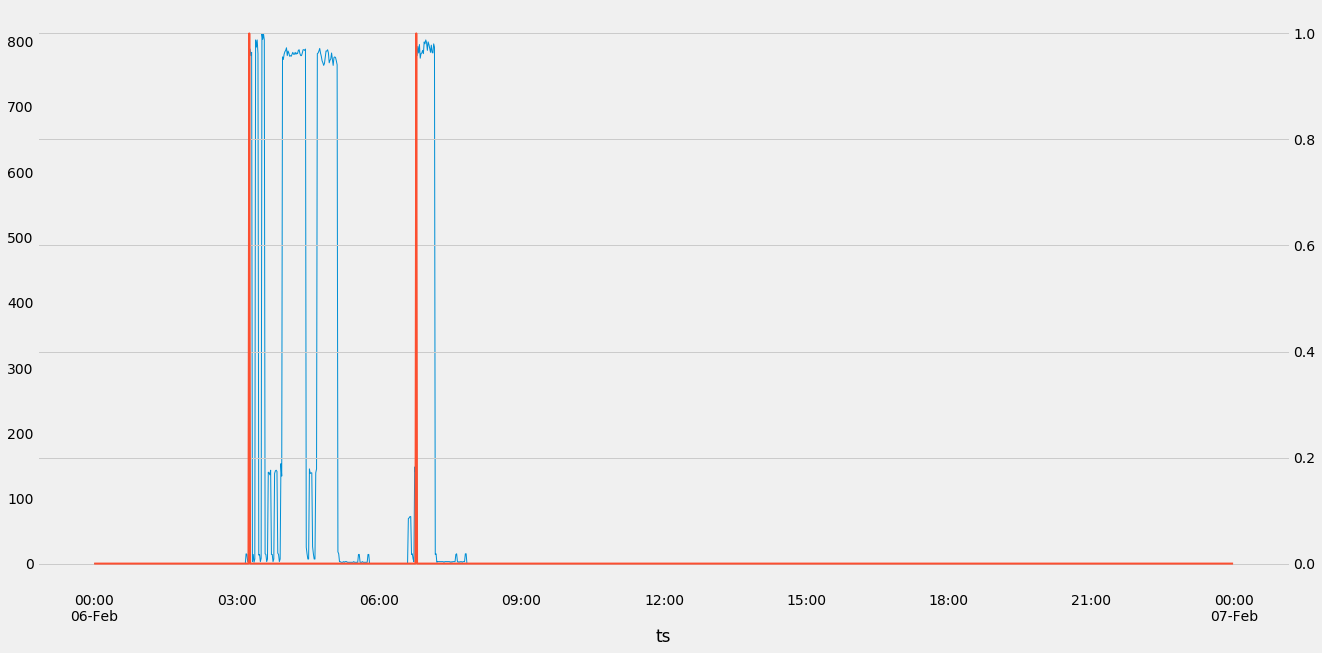

In [31]:
# plot spot checks to see if methodology works
lbl = 'dishwasher'
mask = (df.index.week==6)&(df.index.year==2013)&(df.index.day==6) #&(df.index.hour > 14)
df[lbl][mask].plot(linewidth=1,figsize=(20,10));
df[lbl+'_start'][mask].plot(secondary_y=True,linewidth=2,figsize=(20,10));

In [32]:
# loop through the calculted "start" columns
# find the "1s" and create a countdown starting at 60 mins from that point
# add column to dataframe
for lbl in of_apps:
    res = []
    for val in df[lbl+'_start']:
        if val == 1:
            res.append(60)
        elif not res:
            res.append(0)
        elif val == 0 and res[-1] != 0:
            res.append(res[-1]-1)
        else:
            res.append(0)

    res_shift = res[60:]
    res_shift.extend([0]*60)

    df[lbl+'_countdown'] = res_shift


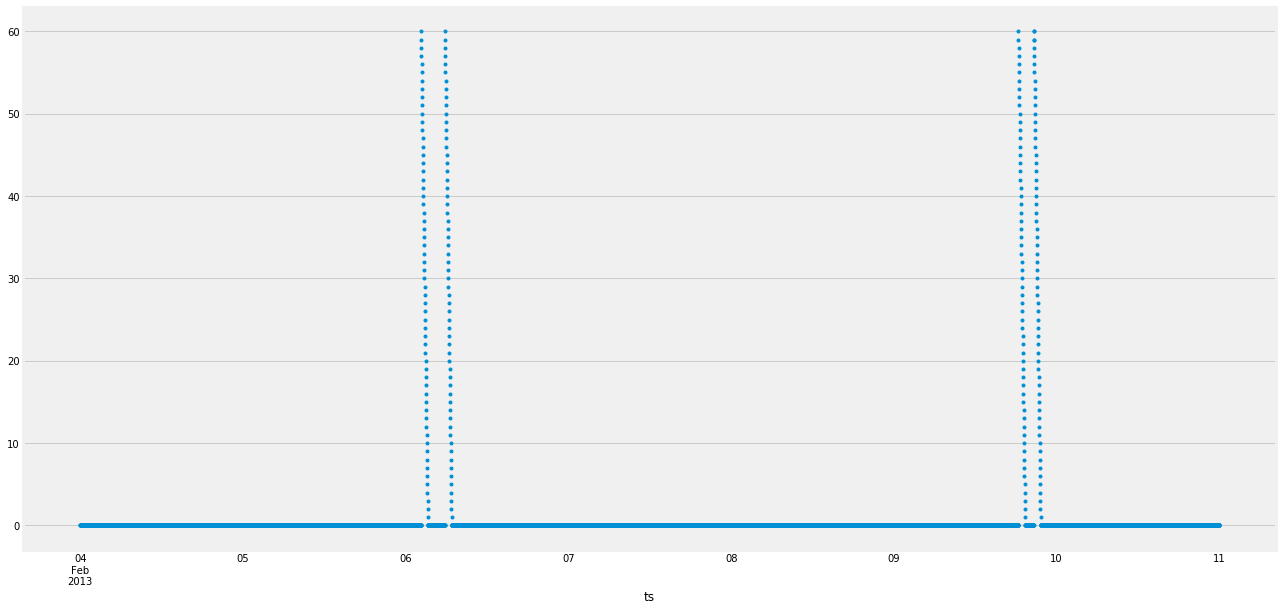

In [16]:
# plot spot checks to see if methodology works
lbl = 'dishwasher'
mask = (df.index.week==6)&(df.index.year==2013)# &(df.index.day==26)&(df.index.hour > 14)
df[lbl+'_countdown'][mask].plot(linewidth=1,figsize=(20,10),style='.');

### Attempt a basic model

In [33]:
feature_cols = ['dow','hour','winter','spring','summer','pos_mht_pct','neg_mht_pct','pos_mht_diff','neg_mht_diff','main_house_total']
# feature_cols = ['dow','hour','winter','spring','summer','pos_mht_diff','neg_mht_diff','main_house_total']
X = df[feature_cols]
y = df['washer_countdown']

tscv = TimeSeriesSplit(n_splits=3)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

In [48]:
# train_size = int(len(X) * 0.66)
# train, test = X[0:train_size], X[train_size:len(X)]

# https://machinelearningmastery.com/backtest-machine-learning-models-time-series-forecasting/

In [ ]:
# plot predictions versus actuals
# determine when they match up and whether prediction actually makes sense



In [34]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_pred)))
list(zip(feature_cols, linreg.coef_))

RMSE: 5.519826778879464


[('dow', 0.07685876915815777),
 ('hour', 0.056773155511373914),
 ('winter', 0.08528532929276154),
 ('spring', 0.14697338453478603),
 ('summer', 0.10129950760775909),
 ('pos_mht_pct', 0.10401848843470103),
 ('neg_mht_pct', 0.10725882850214057),
 ('pos_mht_diff', -0.00011641084669547356),
 ('neg_mht_diff', -0.0001954898176641286),
 ('main_house_total', 0.00018231470884241124)]

In [46]:
a = pd.DataFrame(columns=['yt','yp'])
a['yt'] = y_test
a['yp'] = y_pred
# plt.plot(y_test)
# plt.plot(y_pred)

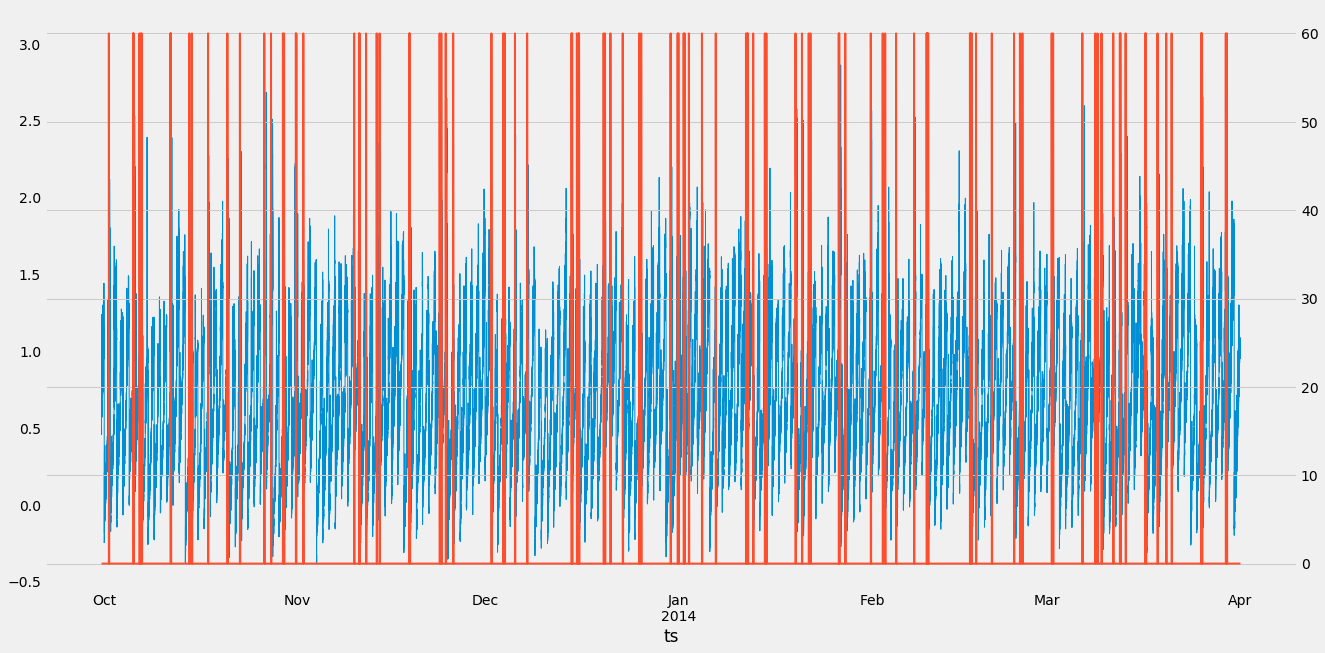

In [49]:
a['yp'].plot(linewidth=1,figsize=(20,10));
a['yt'].plot(secondary_y=True,linewidth=2,figsize=(20,10));

In [50]:
ridgereg = Ridge(alpha=0.1, normalize=True)
ridgereg.fit(X_train, y_train)
y_pred = ridgereg.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
list(zip(feature_cols, ridgereg.coef_))

RMSE: 5.520029021121139


[('dow', 0.07004728653000389),
 ('hour', 0.0514577573028154),
 ('winter', 0.05473805018774841),
 ('spring', 0.1084340958278315),
 ('summer', 0.06312180056949458),
 ('pos_mht_pct', 0.09673844042348195),
 ('neg_mht_pct', 1.0503369640523963e-19),
 ('pos_mht_diff', -9.408151927822519e-05),
 ('neg_mht_diff', -9.46099361391326e-05),
 ('main_house_total', 0.00016141245327007357)]

In [53]:
lasso = Lasso(alpha=0.0001, normalize=True)
lasso.fit(X_train, y_train)
y_pred = lasso.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
list(zip(feature_cols, lasso.coef_))

RMSE: 5.523618718833027


[('dow', 0.033302317506088835),
 ('hour', 0.04276771452318041),
 ('winter', 0.0),
 ('spring', 0.0),
 ('summer', -0.0),
 ('pos_mht_pct', 0.0),
 ('neg_mht_pct', 0.0),
 ('pos_mht_diff', 0.0),
 ('neg_mht_diff', -0.0),
 ('main_house_total', 5.026096073538775e-05)]

In [58]:
treereg = DecisionTreeRegressor()
treereg.fit(X_train,y_train)
y_pred = treereg.predict(X_test)
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

RMSE: 7.818433239668317
